# Calculating Song Similarity using learned song vector representations
## The notebook is organized as follows:
### Song feature representations: 
#### waveform
#### power spectrum
#### mel-spectrum
#### chromagram
### Methods of Inducing a Song Level Vector and Calculating Song Similarity
#### Mean of Sound Vectors
#### Mean and Standard Deviation of Sound Vectors
### Dimensionality Reduction of Sound Vectors
#### Effects of Dimensionality Reduction seen in Mel-Spectrograms
#### Effects of Dimensionality Reduction seen in t-SNE Sound Vector Plots
#### Effects on Mean and Standard Deviation Vector Song Similarity
### NLP Based Methods of Inducing a Song Level Vector and Calculating Song Similarity
#### Map real valued sound vectors to a discrete vocabulary by training a KMeans model
#### Transform songs into lists of sound cluster labels using the KMeans model
#### Train word2vec on large windows of sound cluster labels treated as words in a sentence
#### Use the Fast Sentence Embedding algorithm to induce song level vectors

In [ ]:
import sys

In [ ]:
#Uncomment and run to install

#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install gensim
#!{sys.executable} -m pip install librosa

In [1]:
import sys, os, re, gzip, json, random, math, pickle
import joblib

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import matplotlib.pyplot as plt

import librosa
import librosa.display

import soundfile as sf

%matplotlib inline

In [2]:
data_path = '../data'

# Songs in numbered folders sorted into genre folders
myspace_path = '%s/myspace_mp3s' % data_path

#song metadata
metadata_path = '%s/metadata.json.gz' % myspace_path

#mapping of raw genres to general genres
genre_map_path = '%s/genre_map.pkl' % myspace_path

#extracted audio features stored here (mfcc and melspec as of 12/4/21) See data_prep_2-audio_feature_extraction.ipynb
features_path = '%s/audio_features' % data_path
melspec_path = '%s/melspec' % features_path

samples_path = '%s/samples' % myspace_path

In [3]:
def load_metadata(metadata_path):
    with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
        metadata = json.load(fz)
    return metadata


def load_genre_map(genre_map_path):
    with open(genre_map_path, 'rb') as f:
        genre_map = pickle.load(f)
    return genre_map

In [4]:
metadata = load_metadata(metadata_path)
genre_map = load_genre_map(genre_map_path)

### Sound Feature Types
#### Observe the visual difference between different feature types across different genres. This provides a clue as to which feature type is best suited to representing the songs.

In [5]:
# Load data for 3 different genres - returns the waveform and sample_rate (sr, samples per second; 22050)
waveform_classical, sr = librosa.load('%s/example_classical.mp3' % samples_path)
waveform_electronic, _ = librosa.load('%s/example_electronic.mp3' % samples_path)
waveform_metal, _ = librosa.load('%s/example_metal.mp3' % samples_path)

waveform_classical.shape, waveform_electronic.shape, waveform_metal.shape

c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((6935040,), (7636608,), (7603200,))

#### Plot waveforms
##### Classical - The classical piece is quieter, so it allows a more distinctive waveform shape to be seen.
##### Electronic - The loudness of the electronic piece mostly saturates the waveform at a large scale. Distinct quieter sections are the only large scale forms distinguishable.
##### Metal - The metal piece almost completely saturates the large scale waveform due to it's persistent intensity. A few quieter passages can be seen.

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(waveform_classical, sr=sr)

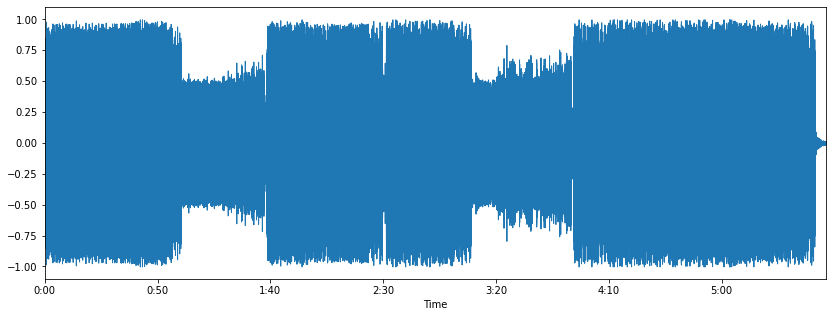

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(waveform_electronic, sr=sr)

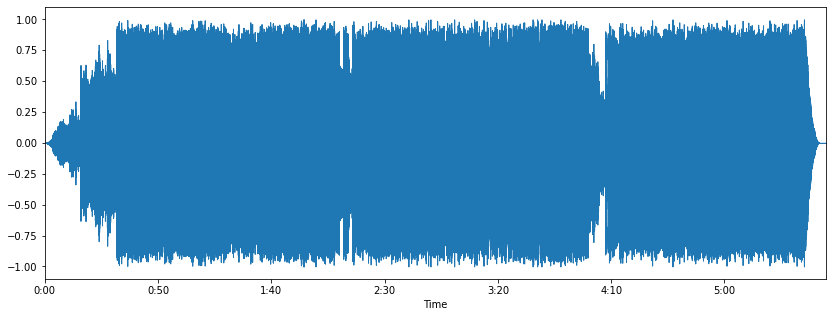

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(waveform_metal, sr=sr)

#### Plot Power Spectrum - the fast Fourier transform applied to the waveform to yield the distribution of power across frequencies

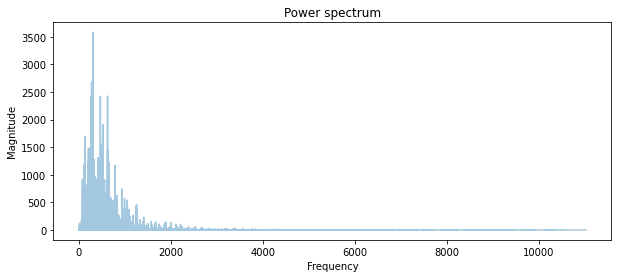

In [201]:
# perform Fourier transform, calculate abs values on complex numbers to get magnitude
spectrum = np.abs(np.fft.fft(waveform_classical))
# create frequency variable
f = np.linspace(0, sr, len(spectrum))
# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]
# plot spectrum
plt.figure(figsize=(10,4))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum')
plt.show()

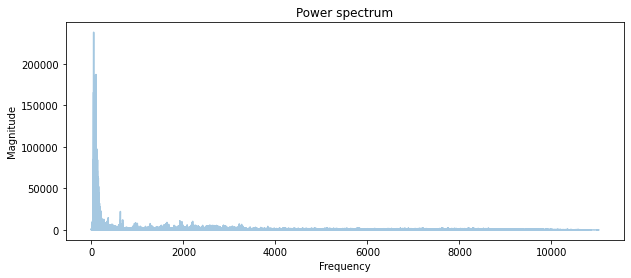

In [202]:
spectrum = np.abs(np.fft.fft(waveform_electronic))
f = np.linspace(0, sr, len(spectrum))
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

plt.figure(figsize=(10,4))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum')
plt.show()

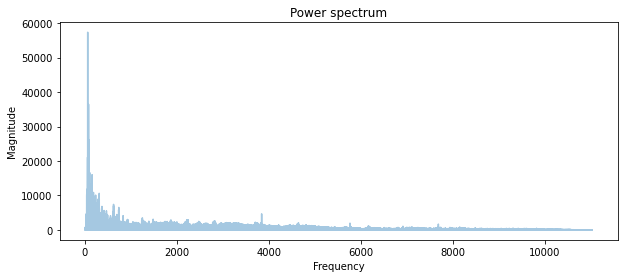

In [203]:
spectrum = np.abs(np.fft.fft(waveform_metal))
f = np.linspace(0, sr, len(spectrum))
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

plt.figure(figsize=(10,4))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum')
plt.show()

#### Plot mel spectrograms
##### Classical - The classical piece is quieter, so the colors are darker. It also has cleaner tones (piano) so it doesn't range over many higher frequencies.
##### Electronic - The electronic piece is louder and therefore brighter. It ranges over a larger frequency range indicating fuller and more complex sounds. The frequency bands are more clearly defined since it is electronically synthesized and therefore not subject to complicated acoustics. It is more distinctly rhythmic.
##### Metal - The metal piece is very loud and has strong signals across the whole frequency spectrum, indicating noise (the distortion from the guitars, etc.). The quieter passages can be distinguished at the beginning and towards the end by the darker areas.  

c:\ml\env\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


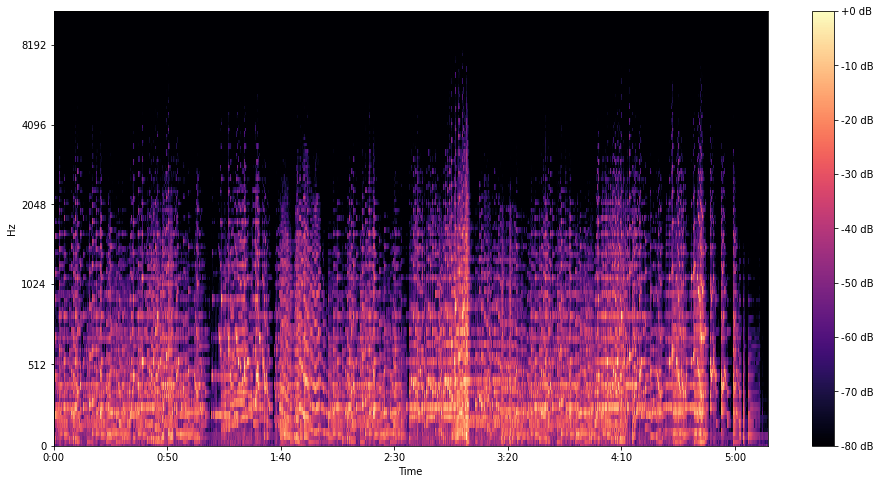

In [6]:
fig, ax = plt.subplots(figsize=(16,8))

melspec_classical = librosa.feature.melspectrogram(waveform_classical, sr=sr, n_mels=128, fmin=20, fmax=16000)

# transform amplitude/power data to decibels
# Note that the decibels are scaled such that 0 is normal baseline volume, ranging to -80 which is undiscernable
melspec_db = librosa.power_to_db(np.abs(melspec_classical), ref=np.max)

img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

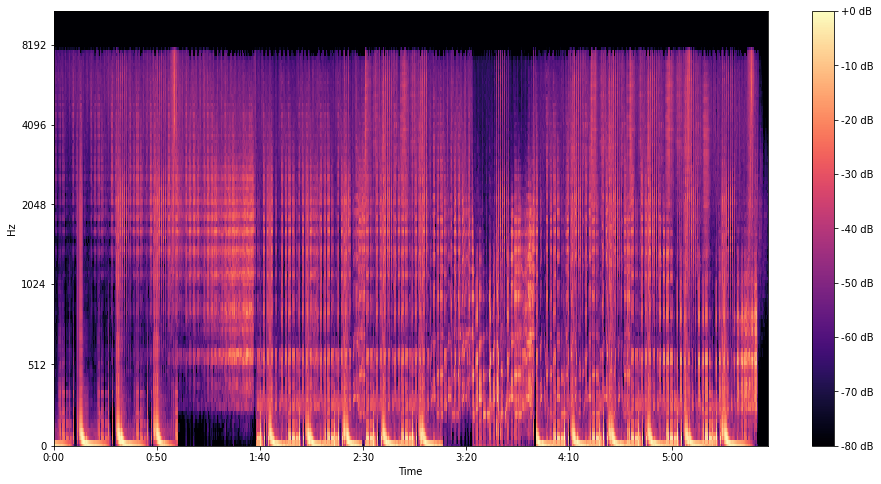

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

melspec_electronic = librosa.feature.melspectrogram(waveform_electronic, sr=sr, n_mels=128, fmin=20, fmax=16000)
melspec_db = librosa.power_to_db(np.abs(melspec_electronic), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)

fig.colorbar(img, ax=ax, format="%+2.f dB")

c:\ml\env\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


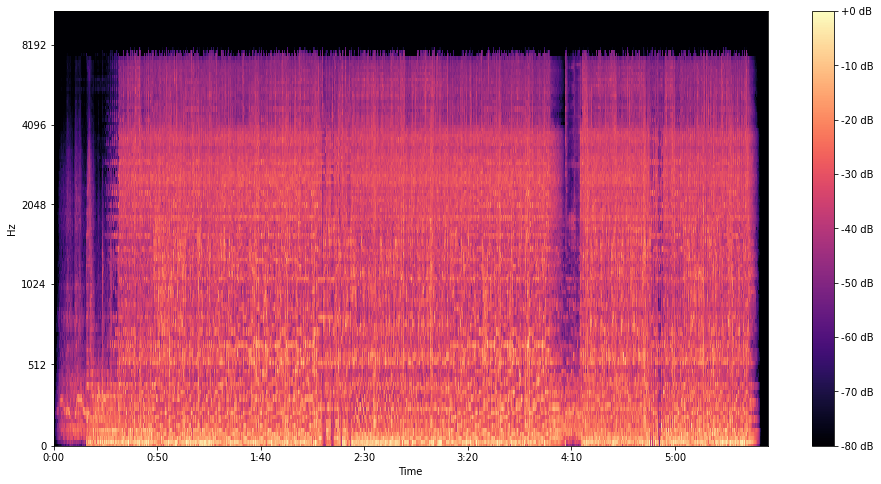

In [128]:
fig, ax = plt.subplots(figsize=(16,8))

melspec_metal = librosa.feature.melspectrogram(waveform_metal, sr=sr, n_mels=128, fmin=20, fmax=16000)
melspec_db = librosa.power_to_db(np.abs(melspec_metal), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)

fig.colorbar(img, ax=ax, format="%+2.f dB")

#### Plot Chromagrams
##### The chromagrams capture pitch information but omit most other valuable information.
##### Note that the classical piece is Beethoven Piano Sonata No. 8, Mvt. 2 in A flat, so notes in the A flat scale (including C, Dflat, Eflat, Bflat)

In [13]:
plt.figure(figsize=(15, 5))

#get the "short time Fourier transform" which is the Fourier transform applied over "short time" windows
chroma_classical = librosa.feature.chroma_stft(waveform_classical, sr=sr, hop_length=512)

librosa.display.specshow(chroma_classical, x_axis='time', y_axis='chroma', hop_length=512)

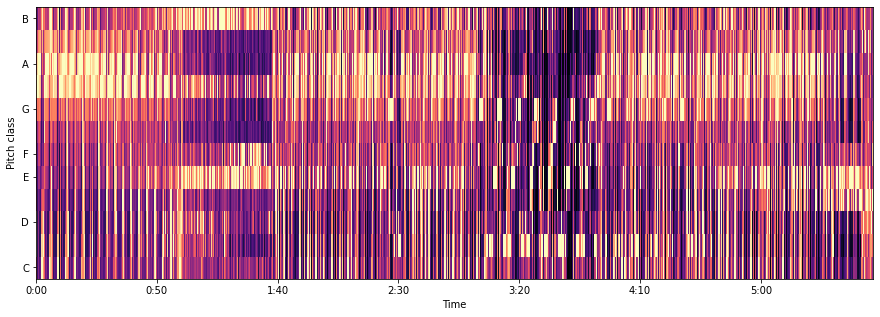

In [14]:
plt.figure(figsize=(15, 5))

chroma_electronic = librosa.feature.chroma_stft(waveform_electronic, sr=sr, hop_length=512)

librosa.display.specshow(chroma_electronic, x_axis='time', y_axis='chroma', hop_length=512)

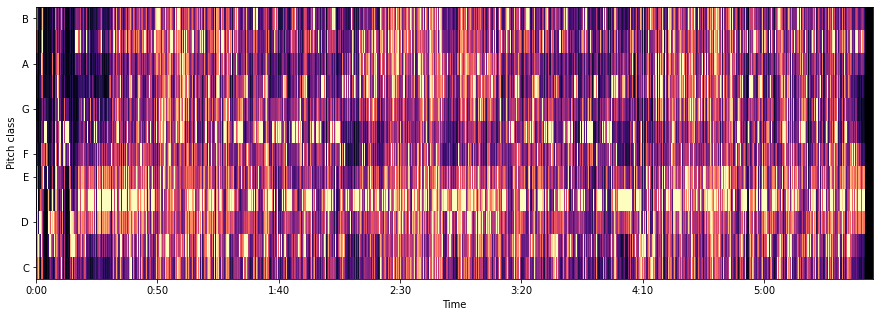

In [15]:
plt.figure(figsize=(15, 5))

chroma_metal = librosa.feature.chroma_stft(waveform_metal, sr=sr, hop_length=512)

librosa.display.specshow(chroma_metal, x_axis='time', y_axis='chroma', hop_length=512)

#### We will use Mel-spectrograms as the song features from which a single vector will be derived for calculating the similarity of songs

In [9]:
def get_song_melspecs_with_single_genre(metadata, genre_map, genre, melspec_path, max_songs):
    '''For training and testing, select prime examples from each genre of interest'''
    single_genre_song_paths_and_meta = {}
    
    missing_file_example = ''
    
    #I have only processed zips 1,2, 10-20 and 78-81
    zips_processed = [1,2]
    zips_processed.extend(range(10,22))
    zips_processed.extend(list(range(78,81)))
    zips_processed = set(zips_processed)
    
    for meta in metadata.values():
        if not int(meta['mp3_zipname']) in zips_processed:
            continue
        
        genres = [genre_map[g] for g in meta['genres'] if g in genre_map]
        if 'other' in genres:
            genres.remove('other')
        if genre=='classical' and 'acoustic' in genres:
            genres.remove('acoustic')
        if genre=='classical' and 'experimental' in genres:
            genres.remove('experimental')
        
        #is it the genre we're looking for and is it the only one?
        if not genre in genres or len(genres)>1:
            continue
        
        #assuming this has been sorted into the genre folder properly, do we have a melspec for it?
        fp = '%s/%s/msp_%s_%s' % (melspec_path, genre, meta['mp3_zipname'], meta['mp3_filename'].replace('.mp3', '.npy'))
        if os.path.exists(fp):
            single_genre_song_paths_and_meta[fp] = meta
        elif genre=='classical' and os.path.exists(fp.replace('classical', 'acoustic')):
            single_genre_song_paths_and_meta[fp.replace('classical', 'acoustic')] = meta
        elif genre=='classical' and os.path.exists(fp.replace('classical', 'experimental')):
            single_genre_song_paths_and_meta[fp.replace('classical', 'experimental')] = meta
        else:            
            if not missing_file_example:
                print('could not find', fp)
                missing_file_example = fp
        
        if len(single_genre_song_paths_and_meta) >= max_songs:
            break
            
    print('Found %d melspec files' % len(single_genre_song_paths_and_meta))
    
    return single_genre_song_paths_and_meta



def collect_genre_samples(genre_melspec_paths, max_samples):
    '''Given the paths to prime examples, load the pre-created melspec arrays,
    stack to get a matrix of sound vectors, and shuffle.'''
    samples = []
    
    per_file = max_samples//len(genre_melspec_paths)
        
    for i, fp in enumerate(genre_melspec_paths):
        if i%100==0:
            print(i, len(samples))

        #melspec is size sound_dim x song_length_by_hops
        melspec = np.load(fp)

        #select random sound vectors from the song
        max_idx = melspec.shape[1]
        idx = np.arange(max_idx)
        np.random.shuffle(idx)

        for ix in idx[:per_file]:
            samples.append(melspec[:, ix])
        
    random.shuffle(samples)
    
    return np.vstack(samples)

In [10]:
classical_melspec_paths_and_meta = get_song_melspecs_with_single_genre(metadata, genre_map, 'classical', melspec_path, max_songs=300)
electronic_melspec_paths_and_meta = get_song_melspecs_with_single_genre(metadata, genre_map, 'electronic', melspec_path, max_songs=300)
metal_melspec_paths_and_meta = get_song_melspecs_with_single_genre(metadata, genre_map, 'metal', melspec_path, max_songs=300)


could not find ../data/audio_features/melspec/classical/msp_17_std_f9ea19bd5a66f6d6121b44031a0f609c.npy
Found 294 melspec files
could not find ../data/audio_features/melspec/electronic/msp_18_std_e320aee2b637be960c9b5ec4e1942873.npy
Found 300 melspec files
could not find ../data/audio_features/melspec/metal/msp_20_std_820f3c19da9ab4c33a6c2c0254a5d77d.npy
Found 300 melspec files


In [11]:
melspecs_classical_path = '%s/melspecs_classical.npy' % samples_path
melspecs_electronic_path = '%s/melspecs_electronic.npy' % samples_path
melspecs_metal_path = '%s/melspecs_metal.npy' % samples_path

if not os.path.exists(melspecs_classical_path):
    classical_melspecs = collect_genre_samples(list(classical_melspec_paths_and_meta.keys()), max_samples=100000)
    electronic_melspecs = collect_genre_samples(list(electronic_melspec_paths_and_meta.keys()), max_samples=100000)
    metal_melspecs = collect_genre_samples(list(metal_melspec_paths_and_meta.keys()), max_samples=100000)

    np.save(melspecs_classical_path, classical_melspecs)
    np.save(melspecs_electronic_path, electronic_melspecs)
    np.save(melspecs_metal_path, metal_melspecs)
else:
    classical_melspecs = np.load(melspecs_classical_path)
    electronic_melspecs = np.load(melspecs_electronic_path)
    metal_melspecs = np.load(melspecs_metal_path)
    
classical_melspecs.shape, electronic_melspecs.shape, metal_melspecs.shape

0 0
100 34000
200 68000
0 0
100 33300
200 66270
0 0
100 33300
200 66600


((99939, 128), (99570, 128), (99900, 128))

In [16]:
#concat resulting prime examples together
melspec_paths_and_meta = {}
melspec_paths_and_meta.update(classical_melspec_paths_and_meta)
melspec_paths_and_meta.update(electronic_melspec_paths_and_meta)
melspec_paths_and_meta.update(metal_melspec_paths_and_meta)

In [12]:
melspec_samples_path = '%s/melspecs_classical_electronic_metal.npy' % samples_path

if not os.path.exists(melspec_samples_path):
    #stack all together
    melspecs = np.vstack((classical_melspecs, electronic_melspecs, metal_melspecs))

    #shuffle
    max_idx = melspecs.shape[0]
    idx = np.arange(max_idx)
    np.random.shuffle(idx)
    melspecs = melspecs[idx]

    np.save(melspec_samples_path, melspecs)
else:
    melspecs = np.load(melspec_samples_path)

melspecs.shape

(299409, 128)

### Explore methods of aggregating along the time dimension to get a single song vector

#### Mean & Standard Deviation
#####  The simplest way to generalize over the time dimension is to take the mean over this dimension. This will primarily preserve information about the distribution of frequencies over the whole song. Additionally taking the standard deviation and concatenating the two will provide extra information about the structure of the time dimension.

In [98]:
def similar_songs(song_vecs, song_vec, song_paths, melspec_paths_and_meta):
    '''The general method for evaluating a vectorization method for finding similar songs'''
    #compute the cosine similarity of the sample song vec against all the samples song vecs
    cosine_sims = np.dot(song_vecs, song_vec)/(np.linalg.norm(song_vecs, axis=1) * np.linalg.norm(song_vec))
    
    #print the highest scoring songs
    sort_idx = np.argsort(cosine_sims).tolist()[::-1]
    for idx in sort_idx[:5]:
        p = song_paths[idx]
        print('%.6f\t%s\n' % (cosine_sims[idx], melspec_paths_and_meta[p]))

In [93]:
def get_song_vectors_by_mean(melspec_paths_and_meta, svd=None):
    '''Vectorize songs by taking mean of all sound vecs. 
    Optional dimensionality reduction model can be provided.'''
    song_vecs_mean = []
    song_paths = []
    
    for fp, meta in melspec_paths_and_meta.items():
        # sounddim x len
        ms = np.load(fp)
        
        vec = get_song_vector_by_mean(ms, svd)
         
        song_vecs_mean.append(vec)
        song_paths.append(fp)
    
    return np.vstack(song_vecs_mean), song_paths


def get_song_vector_by_mean(melspec, svd=None):
    '''Get a single song mean vector'''
    if not svd==None:
        melspec = svd.transform(melspec.T)
        melspec = melspec.T
        
    return melspec.mean(axis=1)

In [94]:
song_vecs_mean, song_paths = get_song_vectors_by_mean(melspec_paths_and_meta)
song_vecs_mean.shape

(894, 128)

In [ ]:
#test with our sample genre songs

In [99]:
song_vec_mean = get_song_vector_by_mean(melspec_classical)
similar_songs(song_vecs_mean, song_vec_mean, song_paths, melspec_paths_and_meta)

0.881578	{'song_name': 'folk_music', 'artist_name': 'sanjay_kumar_sharma', 'mp3_zipname': '10', 'mp3_filename': 'std_3fa07fbdc6273181f2952d51c12594d5.mp3', 'genres': ['classical']}

0.880181	{'song_name': 'la_trouvere', 'artist_name': 'william_ellwood', 'mp3_zipname': '14', 'mp3_filename': 'std_f97af36c58103ef5969c34dfb4fc210c.mp3', 'genres': ['classical', 'acoustic']}

0.875663	{'song_name': 'mr_sandman', 'artist_name': 'the_chordettes', 'mp3_zipname': '2', 'mp3_filename': 'std_99331fccfa6e8d6659ba0c2a087923e6.mp3', 'genres': ["a'cappella"]}

0.874422	{'song_name': '1901', 'artist_name': 'a_filetta', 'mp3_zipname': '78', 'mp3_filename': 'std_781a99bf32c2fc21f581f2c4a607d54c.mp3', 'genres': ["a'cappella"]}

0.869373	{'song_name': 'sheep_may_safely_graze', 'artist_name': 'christopher_parkening', 'mp3_zipname': '18', 'mp3_filename': 'std_dfb6395f15bb2e8bb16c84b7d9e8b50c.mp3', 'genres': ['classical']}



In [100]:
song_vec_mean = get_song_vector_by_mean(melspec_electronic)
similar_songs(song_vecs_mean, song_vec_mean, song_paths, melspec_paths_and_meta)

0.981353	{'song_name': "what's_good_for_me_that_good", 'artist_name': 'maniac_butcher', 'mp3_zipname': '13', 'mp3_filename': 'std_6fa238d48a0a9018f6574c4cf873b9f6.mp3', 'genres': ['black_metal']}

0.973141	{'song_name': 'take_my_beat', 'artist_name': 'boris_divider', 'mp3_zipname': '20', 'mp3_filename': 'std_f45f55c54b0de4825513afac4fcef7a3.mp3', 'genres': ['electro']}

0.968231	{'song_name': 'againagain', 'artist_name': 'sharam_jey', 'mp3_zipname': '18', 'mp3_filename': 'std_aeff3412a32f014274bb984648c4984e.mp3', 'genres': ['electronica']}

0.956263	{'song_name': 'bring_it_on_remix', 'artist_name': 'teenage_bad_girl_pres._nike_windrunner_82', 'mp3_zipname': '79', 'mp3_filename': 'std_daef80617d7108e00c6c225a82729008.mp3', 'genres': ['electro']}

0.936558	{'song_name': 'excerpts_dcom007', 'artist_name': 'boris_divider', 'mp3_zipname': '14', 'mp3_filename': 'std_c2464774e62276f782c686f13ce98cc0.mp3', 'genres': ['electro']}



In [101]:
song_vec_mean = get_song_vector_by_mean(melspec_metal)
similar_songs(song_vecs_mean, song_vec_mean, song_paths, melspec_paths_and_meta)

0.992138	{'song_name': "that's_it", 'artist_name': 's.i.n.a', 'mp3_zipname': '1', 'mp3_filename': 'std_de96c5f8e0c2b0cc607f8a6d5972aad5.mp3', 'genres': ['electronica']}

0.989735	{'song_name': 'the_killer_storm', 'artist_name': 'homerun', 'mp3_zipname': '11', 'mp3_filename': 'std_dd1b1dae4fa5673ab4c3c5a368822b45.mp3', 'genres': ['electronica']}

0.987559	{'song_name': 'vessel', 'artist_name': 'jon_hopkins', 'mp3_zipname': '20', 'mp3_filename': 'std_a92fea0cfdac563f4bb5151c77609a80.mp3', 'genres': ['electronica']}

0.984487	{'song_name': 'infinito__ante_perry_rmx', 'artist_name': 'ante_perry', 'mp3_zipname': '16', 'mp3_filename': 'std_e7481afd9958a9cfd3f65294ed0b7317.mp3', 'genres': ['electronica']}

0.981914	{'song_name': 'audio_freak', 'artist_name': 'adam_sheridan', 'mp3_zipname': '18', 'mp3_filename': 'std_39bc7434601a2a3d4b5428d1c7993e09.mp3', 'genres': ['electronica']}



##### Using only the mean, the song similarity seems to be restricted to measuring frequency saturation. Classical is quieter and has more distinct frequency bands so it works a little for it, but electronic and metal are treated equally.

##### Let's look at the melspecs for the top similar classical pieces

In [106]:
top_melspecs = []
for fp in classical_melspec_paths_and_meta.keys():
    if 'std_3fa07fbdc6273181f2952d51c12594d5' in fp or 'std_f97af36c58103ef5969c34dfb4fc210c' in fp or 'std_99331fccfa6e8d6659ba0c2a087923e6' in fp:
        top_melspecs.append(np.load(fp))

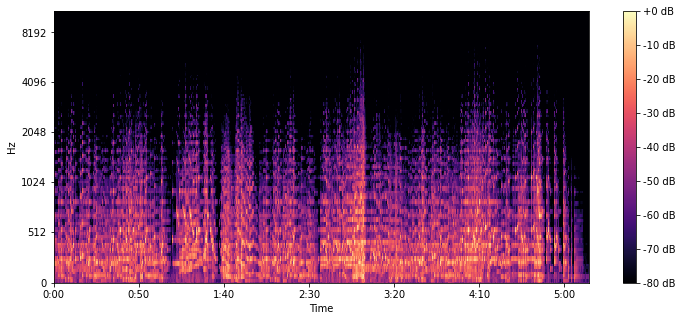

In [113]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(melspec_classical), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

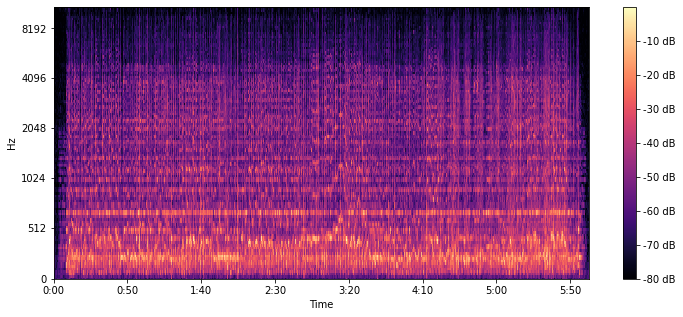

In [110]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_3_melspecs[0]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

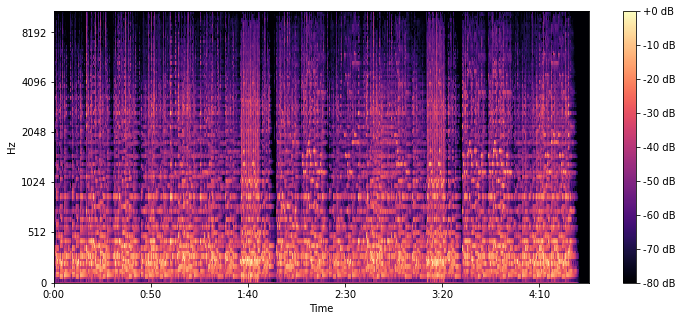

In [111]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_3_melspecs[2]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

##### Use mean and standard deviation concatenated

In [122]:
def get_song_vectors_by_mean_and_std(melspec_paths_and_meta, svd=None):
    '''Vectorize songs by taking mean of all sound vecs and concatenating the standard deviation. 
    Optional dimensionality reduction model can be provided.'''
    song_vecs_mean = []
    song_paths = []
    
    for fp, meta in melspec_paths_and_meta.items():
        # sounddim x len
        ms = np.load(fp)
        
        vec = get_song_vector_by_mean_and_std(ms, svd)
         
        song_vecs_mean.append(vec)
        song_paths.append(fp)
    
    return np.vstack(song_vecs_mean), song_paths


def get_song_vector_by_mean_and_std(melspec, svd=None):
    '''Get mean and std vec for a single song'''
    if not svd==None:
        melspec = svd.transform(melspec.T)
        melspec = melspec.T
        
    return np.concatenate((melspec.mean(axis=1), melspec.std(axis=1)))

In [123]:
song_vecs_mean_and_std, song_paths = get_song_vectors_by_mean_and_std(melspec_paths_and_meta)
song_vecs_mean_and_std.shape

(894, 256)

In [125]:
song_vec_mean_and_std = get_song_vector_by_mean_and_std(melspec_classical)
similar_songs(song_vecs_mean_and_std, song_vec_mean_and_std, song_paths, melspec_paths_and_meta)

0.860999	{'song_name': 'mr_sandman', 'artist_name': 'the_chordettes', 'mp3_zipname': '2', 'mp3_filename': 'std_99331fccfa6e8d6659ba0c2a087923e6.mp3', 'genres': ["a'cappella"]}

0.854849	{'song_name': 'the_coca_cola_song', 'artist_name': 'the_flying_pickets', 'mp3_zipname': '18', 'mp3_filename': 'std_31b18466f7c6875e5616e5bface9394e.mp3', 'genres': ["a'cappella"]}

0.829926	{'song_name': 'shboom', 'artist_name': 'the_alley_cats', 'mp3_zipname': '79', 'mp3_filename': 'std_1f8505d494aa6b555ccc67ba24eef91e.mp3', 'genres': ["a'cappella"]}

0.818840	{'song_name': 'ill_be_seeing_you', 'artist_name': 'jimmy_durante', 'mp3_zipname': '18', 'mp3_filename': 'std_d4a52f7f91cb9627a9f20c23beada1f3.mp3', 'genres': ['classical']}

0.809535	{'song_name': '1901', 'artist_name': 'a_filetta', 'mp3_zipname': '78', 'mp3_filename': 'std_781a99bf32c2fc21f581f2c4a607d54c.mp3', 'genres': ["a'cappella"]}



In [126]:
song_vec_mean_and_std = get_song_vector_by_mean_and_std(melspec_electronic)
similar_songs(song_vecs_mean_and_std, song_vec_mean_and_std, song_paths, melspec_paths_and_meta)

0.978589	{'song_name': 'againagain', 'artist_name': 'sharam_jey', 'mp3_zipname': '18', 'mp3_filename': 'std_aeff3412a32f014274bb984648c4984e.mp3', 'genres': ['electronica']}

0.971946	{'song_name': 'take_my_beat', 'artist_name': 'boris_divider', 'mp3_zipname': '20', 'mp3_filename': 'std_f45f55c54b0de4825513afac4fcef7a3.mp3', 'genres': ['electro']}

0.970257	{'song_name': 'excerpts_dcom007', 'artist_name': 'boris_divider', 'mp3_zipname': '14', 'mp3_filename': 'std_c2464774e62276f782c686f13ce98cc0.mp3', 'genres': ['electro']}

0.946867	{'song_name': "devil's_dream_v03", 'artist_name': 'e-bison', 'mp3_zipname': '1', 'mp3_filename': 'std_effc7790b8b937c8e970e3a4fbe8c9d1.mp3', 'genres': ['electronica']}

0.946415	{'song_name': 'the_killer_storm', 'artist_name': 'homerun', 'mp3_zipname': '11', 'mp3_filename': 'std_dd1b1dae4fa5673ab4c3c5a368822b45.mp3', 'genres': ['electronica']}



In [129]:
song_vec_mean_and_std = get_song_vector_by_mean_and_std(melspec_metal)
similar_songs(song_vecs_mean_and_std, song_vec_mean_and_std, song_paths, melspec_paths_and_meta)

0.988889	{'song_name': "that's_it", 'artist_name': 's.i.n.a', 'mp3_zipname': '1', 'mp3_filename': 'std_de96c5f8e0c2b0cc607f8a6d5972aad5.mp3', 'genres': ['electronica']}

0.975445	{'song_name': 'tangerine_dubbie', 'artist_name': 'andres_bucci', 'mp3_zipname': '19', 'mp3_filename': 'std_e9c5c9fb9556cd14bd2a7ff95581e970.mp3', 'genres': ['electronica']}

0.966468	{'song_name': 'fabulous', 'artist_name': 'melnyk', 'mp3_zipname': '18', 'mp3_filename': 'std_d3841ebc9232091fea883973886949b6.mp3', 'genres': ['electro']}

0.963645	{'song_name': 'undertow', 'artist_name': 'sijay_james', 'mp3_zipname': '14', 'mp3_filename': 'std_4be3134d514ac0fb484af012ece65c1d.mp3', 'genres': ['electronica']}

0.962582	{'song_name': 'the_killer_storm', 'artist_name': 'homerun', 'mp3_zipname': '11', 'mp3_filename': 'std_dd1b1dae4fa5673ab4c3c5a368822b45.mp3', 'genres': ['electronica']}



##### Including the std with the mean appears to make the similarity a little more sensitive to variations along the time dimension, but we have the same problem of electronic and metal being equated.

In [130]:
top_melspecs = []
for fp in classical_melspec_paths_and_meta.keys():
    if 'std_99331fccfa6e8d6659ba0c2a087923e6' in fp or 'std_31b18466f7c6875e5616e5bface9394e' in fp or 'std_c2464774e62276f782c686f13ce98cc0' in fp:
        top_melspecs.append(np.load(fp))

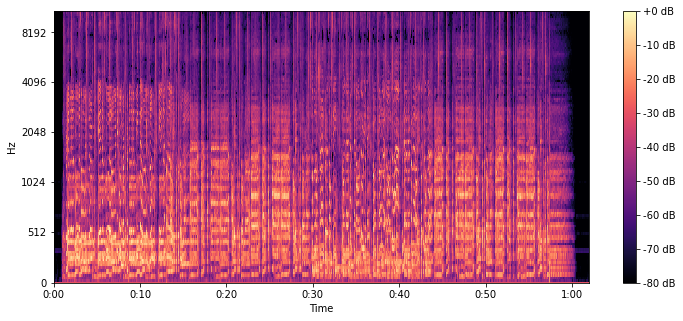

In [131]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_melspecs[0]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

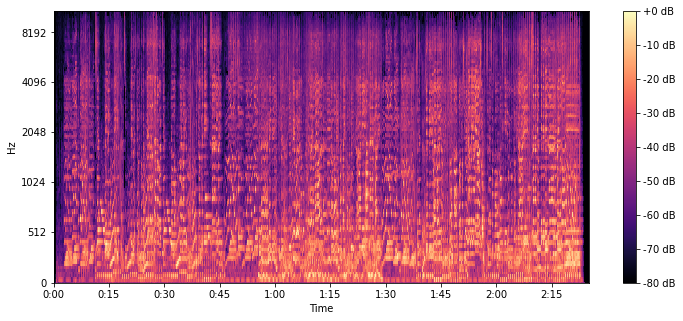

In [132]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_melspecs[1]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

#### Dimensionality Reduction with Singular Value Decomposition
##### Next we can try the mean & std models on mel-specs with reduced dimentions. Reducing the dimensions may serve to concentrate certain structures in a way that might preserve them. Here we perform sound dimension reduction via Singular Value Decomposition. To see the effect of each dimension reduction we plot the spectrogram resulting from reducing the dimension and then inversing that action to retrieve a matrix of the original size. We also plot t-SNE for our 3 genre examples to examine sound clustering and the effects of dimensionality reduction on the clusters.

In [135]:
def train_svd(dim, melspecs):
    '''Train an SVD model'''
    svd = TruncatedSVD(n_components=dim)
    svd.fit(melspecs)

    print('Variance explained by %d SVD components: %.8f' % (dim, sum(svd.explained_variance_ratio_)))
    
    return svd

    
def plot_regenerated_melspec(svd, sample_melspec):
    '''Reduce a melspec and then invert the operation and plot the result to see information loss'''
    reduced_melspec = svd.transform(sample_melspec.T)
    print('New melspec shape:', reduced_melspec.shape)
    
    reconstructed_melspec = svd.inverse_transform(reduced_melspec)

    #plot spectrogram to see difference
    fig, ax = plt.subplots(figsize=(12,8))
    melspec_db = librosa.power_to_db(np.abs(reconstructed_melspec.T), ref=np.max)
    img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    

def regenerate_audio(svd, sample_melspec, regenerated_audio_path):
    '''Reduce a melspec and then invert the operation and generate an audio file to hear the information loss.
    This is slow so we only do the first 1000 time frames.'''
    reduced_melspec = svd.transform(sample_melspec.T)
    reconstructed_melspec = svd.inverse_transform(reduced_melspec)
    
    print('Writing portion of reduced melspec sample audio file to %s' % regenerated_audio_path)
    n_fft=2048
    n_iter=16
    sr = 22050
    melspec_audio = librosa.feature.inverse.mel_to_audio(reconstructed_melspec.T[:,:1000], sr=sr, n_fft=n_fft, n_iter=n_iter)
    sf.write(regenerated_audio_path, melspec_audio, sr, 'PCM_24')

In [136]:
dim=64
svd64 = train_svd(dim, melspecs)
#save trained svd model
joblib.dump(svd64, 'svd%d.joblib' % dim)

regenerate_audio(svd64, melspec_classical, 'reconstructed_melspec_svd64_classical.wav')

plot_regenerated_melspec(svd64, melspec_classical)

Variance explained by 64 SVD components: 0.99960872
New melspec shape: (13546, 64)


In [137]:
dim=32
svd32 = train_svd(dim, melspecs)
joblib.dump(svd32, 'svd%d.joblib' % dim)

regenerate_audio(svd32, melspec_classical, 'reconstructed_melspec_svd32_classical.wav')

plot_regenerated_melspec(svd32, melspec_classical)

Variance explained by 32 SVD components: 0.99147118
New melspec shape: (13546, 32)


Variance explained by 16 SVD components: 0.96368620
New melspec shape: (13546, 16)


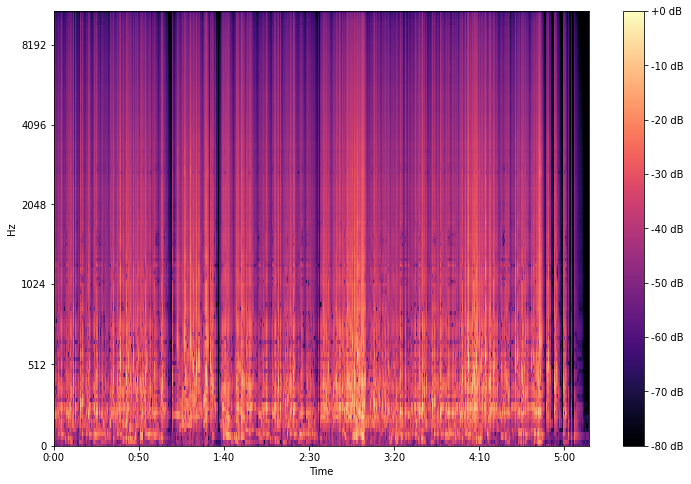

In [138]:
dim=16
svd16 = train_svd(dim, melspecs)
joblib.dump(svd16, 'svd%d.joblib' % dim)

#regenerate_audio(svd16, melspec_classical, 'reconstructed_melspec_svd16_classical.wav')

plot_regenerated_melspec(svd16, melspec_classical)

In [139]:
dim=8
svd8 = train_svd(dim, melspecs)
joblib.dump(svd8, 'svd%d.joblib' % dim)

#regenerate_audio(svd8, melspec_classical, 'reconstructed_melspec_svd8_classical.wav')

plot_regenerated_melspec(svd8, melspec_classical)

Variance explained by 8 SVD components: 0.92143651
New melspec shape: (13546, 8)


##### It's clear to see the effect of the dimensionality reduction; the high frequency details are lost. The resulting audio files get more and more "tinny" sounding.

#### Plot t-SNE clusters of sounds for the different genre samples at different dimensionalities.
##### Note that the electronic music displays very distinct structures/manifolds which t-SNE captures well. Classical is the next most distinct and the clusters here most likely correspond to individual piano notes & chords. Metal, as expected, has the least distinct structures since the frequency is so spread out.

In [14]:
def plot_tsne_genre_samples(melspec_classical, melspec_electronic, melspec_metal):
    '''Train a t-SNE model on the first 5000 sound vecs of each genre sample and plot.'''
    perp=30
    n_iter=1000
    
    melspec_classical, melspec_electronic, melspec_metal = melspec_classical.T, melspec_electronic.T, melspec_metal.T
    
    melspecs = np.vstack((melspec_classical[:5000], melspec_electronic[:5000], melspec_metal[:5000]))

    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(melspecs)

    vis_x = tsne_results[:,0]
    vis_y = tsne_results[:,1]

    fig, ax = plt.subplots(figsize=(14,14))

    ax.scatter(vis_x[:5000], vis_y[:5000], c = 'blue', label = 'classical', s=10)
    ax.scatter(vis_x[5000:10001], vis_y[5000:10001], c = 'red', label = 'electronic', s=10)
    ax.scatter(vis_x[10001:15001], vis_y[10001:15001], c = 'aqua', label = 'metal', s=10)

    ax.legend()
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 3.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

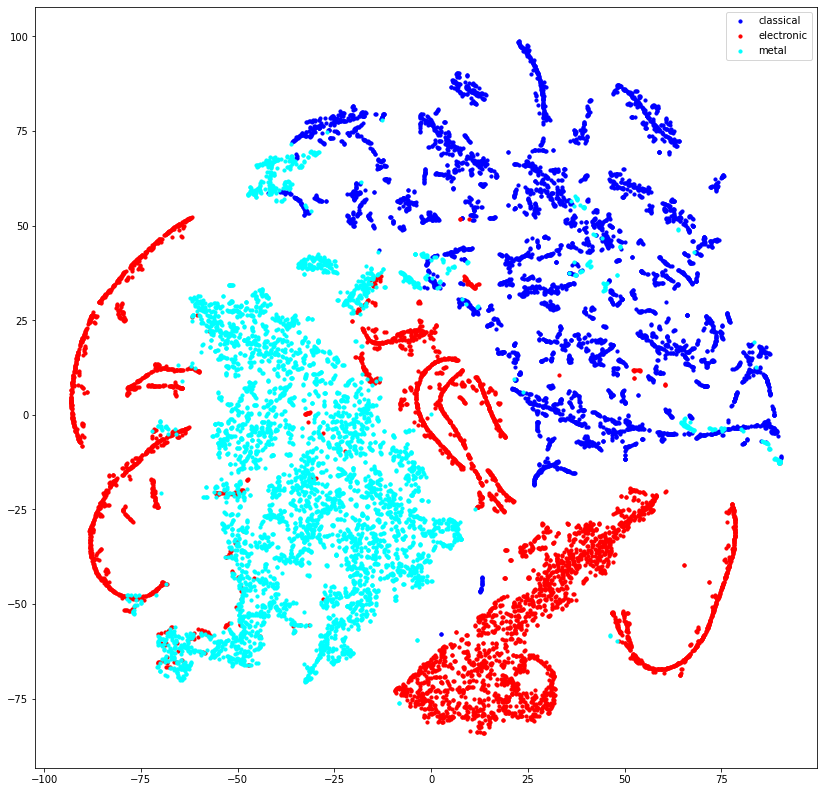

In [100]:
# Plot original 128 dim mel specs

# Note that the electronic music displays very distinct structures/manifolds which t-SNE captures well.
# Classical is the next most distinct and the clusters here most likely correspond to individual piano notes & chords.
# Metal, as expected, has the least distinct structures since the frequency is so spread out.

plot_tsne_genre_samples(melspec_classical, melspec_electronic, melspec_metal)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.000s...
[t-SNE] Computed neighbors for 15000 samples in 3.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

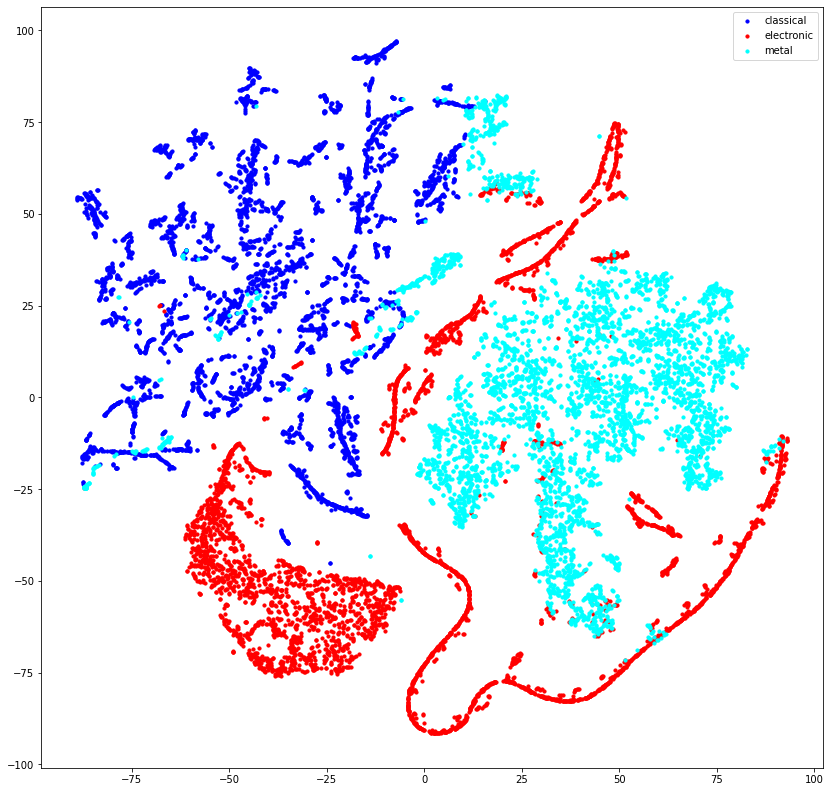

In [107]:
#plot 64 dim melspec
melspec64_classical = svd64_model.transform(melspec_classical.T)
melspec64_electronic  = svd64_model.transform(melspec_electronic.T)
melspec64_metal = svd64_model.transform(melspec_metal.T)

plot_tsne_genre_samples(melspec64_classical.T, melspec64_electronic.T, melspec64_metal.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 3.730s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

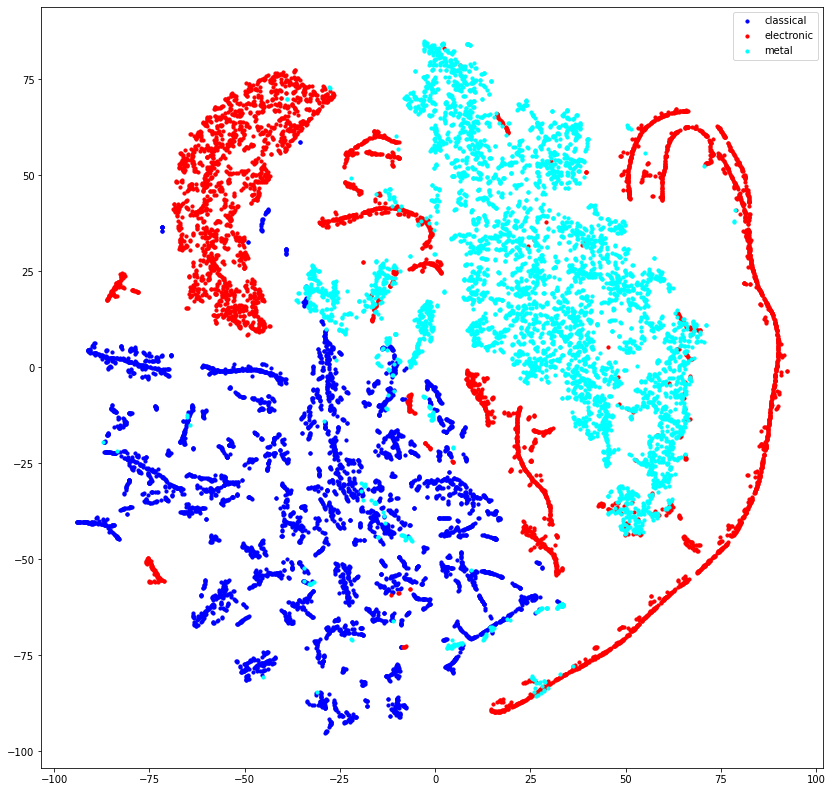

In [108]:
#plot 32 dim melspec
melspec32_classical = svd32_model.transform(melspec_classical.T)
melspec32_electronic  = svd32_model.transform(melspec_electronic.T)
melspec32_metal = svd32_model.transform(melspec_metal.T)

plot_tsne_genre_samples(melspec32_classical.T, melspec32_electronic.T, melspec32_metal.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 3.569s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

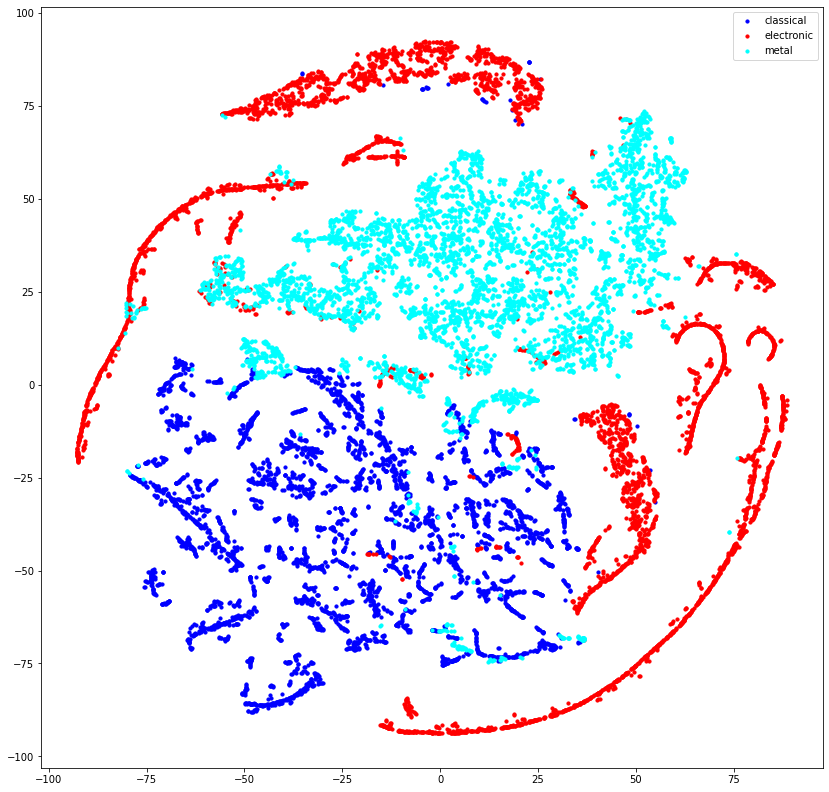

In [109]:
#plot 16 dim melspec - the classical clusters are perhaps becoming a little less distinct

melspec16_classical = svd16_model.transform(melspec_classical.T)
melspec16_electronic  = svd16_model.transform(melspec_electronic.T)
melspec16_metal = svd16_model.transform(melspec_metal.T)

plot_tsne_genre_samples(melspec16_classical.T, melspec16_electronic.T, melspec16_metal.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.024s...
[t-SNE] Computed neighbors for 15000 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

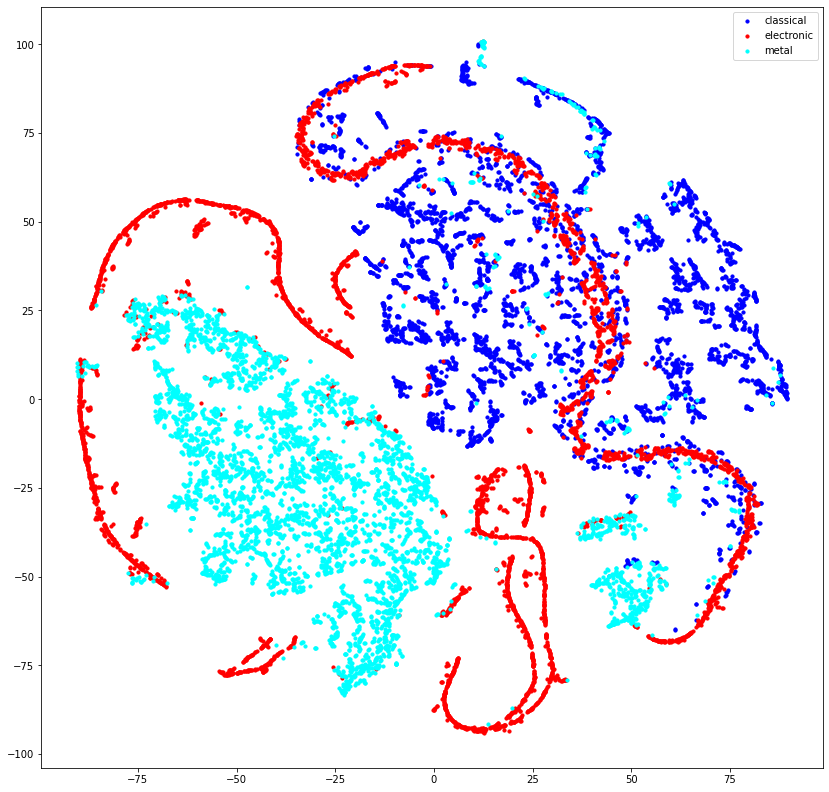

In [110]:
#plot 8 dim melspec - at this point, the structures start overlapping significantly

melspec8_classical = svd8_model.transform(melspec_classical.T)
melspec8_electronic  = svd8_model.transform(melspec_electronic.T)
melspec8_metal = svd8_model.transform(melspec_metal.T)

plot_tsne_genre_samples(melspec8_classical.T, melspec8_electronic.T, melspec8_metal.T)

##### Try reducing the dimension first to capture the essential components prior to constructing the mean & std vector 

In [140]:
#dimension 32

song_vecs_mean_and_std_32, song_paths = get_song_vectors_by_mean_and_std(melspec_paths_and_meta, svd32)
song_vecs_mean_and_std_32.shape

(894, 64)

In [141]:
song_vec_mean_and_std_32 = get_song_vector_by_mean_and_std(melspec_classical, svd32)
similar_songs(song_vecs_mean_and_std_32, song_vec_mean_and_std_32, song_paths, melspec_paths_and_meta)

0.957327	{'song_name': 'concerto_in_mi_minore', 'artist_name': 'pietro_nardini', 'mp3_zipname': '17', 'mp3_filename': 'std_0ccae5b278613dfa823224140d39aa37.mp3', 'genres': ['classical']}

0.953223	{'song_name': 'mr_sandman', 'artist_name': 'the_chordettes', 'mp3_zipname': '2', 'mp3_filename': 'std_99331fccfa6e8d6659ba0c2a087923e6.mp3', 'genres': ["a'cappella"]}

0.952220	{'song_name': 'fac_ut_portem_christi_mortem', 'artist_name': 'giovanni_battista_pergolesi', 'mp3_zipname': '79', 'mp3_filename': 'std_7be95cb28a6927f95c944373f91ba4ae.mp3', 'genres': ['classical_-_opera_and_vocal']}

0.950173	{'song_name': 'debussy_prelude_book_1_no_6', 'artist_name': 'ivan_moravec', 'mp3_zipname': '15', 'mp3_filename': 'std_fd63815385ca17212c06469faab93104.mp3', 'genres': ['classical']}

0.948040	{'song_name': 'fifine_at_the_fair_part_three', 'artist_name': 'granville_bantock', 'mp3_zipname': '78', 'mp3_filename': 'std_8fad79ad1376bd0e466c3a0012de166f.mp3', 'genres': ['classical']}



In [142]:
song_vec_mean_and_std_32 = get_song_vector_by_mean_and_std(melspec_electronic, svd32)
similar_songs(song_vecs_mean_and_std_32, song_vec_mean_and_std_32, song_paths, melspec_paths_and_meta)

0.989509	{'song_name': 'againagain', 'artist_name': 'sharam_jey', 'mp3_zipname': '18', 'mp3_filename': 'std_aeff3412a32f014274bb984648c4984e.mp3', 'genres': ['electronica']}

0.976469	{'song_name': 'fazed', 'artist_name': 'signor_andreoni', 'mp3_zipname': '13', 'mp3_filename': 'std_0c14246b0477b398b2e1206ab5836ca0.mp3', 'genres': ['electronica']}

0.972983	{'song_name': 'take_my_beat', 'artist_name': 'boris_divider', 'mp3_zipname': '20', 'mp3_filename': 'std_f45f55c54b0de4825513afac4fcef7a3.mp3', 'genres': ['electro']}

0.971449	{'song_name': 'excerpts_dcom007', 'artist_name': 'boris_divider', 'mp3_zipname': '14', 'mp3_filename': 'std_c2464774e62276f782c686f13ce98cc0.mp3', 'genres': ['electro']}

0.970766	{'song_name': 'vessel', 'artist_name': 'jon_hopkins', 'mp3_zipname': '20', 'mp3_filename': 'std_a92fea0cfdac563f4bb5151c77609a80.mp3', 'genres': ['electronica']}



In [143]:
song_vec_mean_and_std_32 = get_song_vector_by_mean_and_std(melspec_metal, svd32)
similar_songs(song_vecs_mean_and_std_32, song_vec_mean_and_std_32, song_paths, melspec_paths_and_meta)

0.984384	{'song_name': 'audio_freak', 'artist_name': 'adam_sheridan', 'mp3_zipname': '18', 'mp3_filename': 'std_39bc7434601a2a3d4b5428d1c7993e09.mp3', 'genres': ['electronica']}

0.984336	{'song_name': "that's_it", 'artist_name': 's.i.n.a', 'mp3_zipname': '1', 'mp3_filename': 'std_de96c5f8e0c2b0cc607f8a6d5972aad5.mp3', 'genres': ['electronica']}

0.982988	{'song_name': 'fabulous', 'artist_name': 'melnyk', 'mp3_zipname': '18', 'mp3_filename': 'std_d3841ebc9232091fea883973886949b6.mp3', 'genres': ['electro']}

0.981990	{'song_name': 'programmer', 'artist_name': 'martin_buttrich', 'mp3_zipname': '12', 'mp3_filename': 'std_f78c223d5dfdc43c1e9b789a80fcfe6b.mp3', 'genres': ['electronica']}

0.977486	{'song_name': 'infinito__ante_perry_rmx', 'artist_name': 'ante_perry', 'mp3_zipname': '16', 'mp3_filename': 'std_e7481afd9958a9cfd3f65294ed0b7317.mp3', 'genres': ['electronica']}



In [144]:
# Does it still work with 8?
song_vecs_mean_and_std_8, song_paths = get_song_vectors_by_mean_and_std(melspec_paths_and_meta, svd8)
song_vecs_mean_and_std_8.shape

(894, 16)

In [145]:
song_vec_mean_and_std_8 = get_song_vector_by_mean_and_std(melspec_classical, svd8)
similar_songs(song_vecs_mean_and_std_8, song_vec_mean_and_std_8, song_paths, melspec_paths_and_meta)

0.974335	{'song_name': 'hindemith_horn_concerto_mvti', 'artist_name': 'dennis_brain', 'mp3_zipname': '13', 'mp3_filename': 'std_d8ef20403799faedf3f99ba7f3551950.mp3', 'genres': ['classical']}

0.973537	{'song_name': 'symphony_unfinished_i', 'artist_name': 'franz_schubert', 'mp3_zipname': '1', 'mp3_filename': 'std_3869ddcf2fea661146a1bef9a6c68dfd.mp3', 'genres': ['classical_-_opera_and_vocal']}

0.971859	{'song_name': 'concerto_in_mi_minore', 'artist_name': 'pietro_nardini', 'mp3_zipname': '17', 'mp3_filename': 'std_0ccae5b278613dfa823224140d39aa37.mp3', 'genres': ['classical']}

0.962028	{'song_name': "l'eta'_dell'oro", 'artist_name': 'luigi_maiello', 'mp3_zipname': '21', 'mp3_filename': 'std_9a55b7ebd403fb4d2a4433e9c2d4abf5.mp3', 'genres': ['classical', 'electroacoustic']}

0.961271	{'song_name': 'symphony_unfinished_ii', 'artist_name': 'franz_schubert', 'mp3_zipname': '79', 'mp3_filename': 'std_f7904a5ce3cb71fe5107e032c02bc193.mp3', 'genres': ['classical_-_opera_and_vocal']}



In [146]:
song_vec_mean_and_std_8 = get_song_vector_by_mean_and_std(melspec_electronic, svd8)
similar_songs(song_vecs_mean_and_std_8, song_vec_mean_and_std_8, song_paths, melspec_paths_and_meta)

0.989957	{'song_name': 'againagain', 'artist_name': 'sharam_jey', 'mp3_zipname': '18', 'mp3_filename': 'std_aeff3412a32f014274bb984648c4984e.mp3', 'genres': ['electronica']}

0.976803	{'song_name': 'fazed', 'artist_name': 'signor_andreoni', 'mp3_zipname': '13', 'mp3_filename': 'std_0c14246b0477b398b2e1206ab5836ca0.mp3', 'genres': ['electronica']}

0.974350	{'song_name': 'take_my_beat', 'artist_name': 'boris_divider', 'mp3_zipname': '20', 'mp3_filename': 'std_f45f55c54b0de4825513afac4fcef7a3.mp3', 'genres': ['electro']}

0.973710	{'song_name': 'vessel', 'artist_name': 'jon_hopkins', 'mp3_zipname': '20', 'mp3_filename': 'std_a92fea0cfdac563f4bb5151c77609a80.mp3', 'genres': ['electronica']}

0.971724	{'song_name': 'excerpts_dcom007', 'artist_name': 'boris_divider', 'mp3_zipname': '14', 'mp3_filename': 'std_c2464774e62276f782c686f13ce98cc0.mp3', 'genres': ['electro']}



In [147]:
song_vec_mean_and_std_8 = get_song_vector_by_mean_and_std(melspec_metal, svd8)
similar_songs(song_vecs_mean_and_std_8, song_vec_mean_and_std_8, song_paths, melspec_paths_and_meta)

0.988916	{'song_name': 'fabulous', 'artist_name': 'melnyk', 'mp3_zipname': '18', 'mp3_filename': 'std_d3841ebc9232091fea883973886949b6.mp3', 'genres': ['electro']}

0.987891	{'song_name': "that's_it", 'artist_name': 's.i.n.a', 'mp3_zipname': '1', 'mp3_filename': 'std_de96c5f8e0c2b0cc607f8a6d5972aad5.mp3', 'genres': ['electronica']}

0.987263	{'song_name': 'programmer', 'artist_name': 'martin_buttrich', 'mp3_zipname': '12', 'mp3_filename': 'std_f78c223d5dfdc43c1e9b789a80fcfe6b.mp3', 'genres': ['electronica']}

0.986162	{'song_name': 'audio_freak', 'artist_name': 'adam_sheridan', 'mp3_zipname': '18', 'mp3_filename': 'std_39bc7434601a2a3d4b5428d1c7993e09.mp3', 'genres': ['electronica']}

0.982068	{'song_name': 'tangerine_dubbie', 'artist_name': 'andres_bucci', 'mp3_zipname': '19', 'mp3_filename': 'std_e9c5c9fb9556cd14bd2a7ff95581e970.mp3', 'genres': ['electronica']}



#### Performing SVD on the melspecs yields comparable similarity results, even at dimension 8.

### Applying NLP Methods to Sounds as Words and Songs as Sentences/Documents
#### If the real valued mel-spec vectors could be mapped to a discrete "sound vocabulary" the NLP techniques such as word2vec could be used to embed them individually and doc2vec or fast sentence embedding methods could be used to create a representative vector for each song.
#### We will try k-means clustering on the mel-spec sound vectors and treat each cluster as a "word". Then each song can be converted into a "sentence" and we can train a Word2Vec model and then create a vector from the sentence using the Fast Sentence Embedding method.

In [148]:
def train_kmeans(melspecs, kmeans_path, n_clusters=10000):
    kmeans = MiniBatchKMeans(n_clusters)

    batch_size=10000
    batches = (melspecs.shape[0]//batch_size)+1
    for i in range(batches):
        print(i)
        melspec_batch = melspecs[i*batch_size:(i+1)*batch_size]
        kmeans = kmeans.partial_fit(melspec_batch)
        
    joblib.dump(kmeans, kmeans_path)
    
    return kmeans

In [17]:
n_clusters=10000
kmeans_path = 'melspec%d_kmeans%d.joblib' % (melspecs.shape[1], n_clusters)

if os.path.exists(kmeans_path):
    print('Loading trained kmeans')
    kmeans = joblib.load(kmeans_path)
else:
    kmeans = train_kmeans(melspecs, kmeans_path, n_clusters)

Loading trained kmeans


In [67]:
def songs_to_text(kmeans, melspec_paths_and_meta):
    '''For each song, for each melspec vector, get its cluster label and store in a list'''
    vocab_cts={}
    fn_sound_labs = {}
    
    for i, fp in enumerate(melspec_paths_and_meta.keys()):
        if i%50==0:
            print(i, fp)
            
        melspec = np.load(song_path)
        
        sound_labs = song_to_text(melspec, kmeans, vocab_cts)
        fn_sound_labs[fp] = sound_labs
    
    return fn_sound_labs, vocab_cts


def song_to_text(melspec, kmeans, vocab_cts={}):
    sound_labs = []
    
    melspec = melspec.T
    cs = kmeans.predict(melspec)

    for j in range(cs.shape[0]):
        c = cs[j]
        lab = 'sound_%d' % c

        if not lab in vocab_cts:
            vocab_cts[lab] = 0
        vocab_cts[lab] += 1

        sound_labs.append(lab)
        
    return sound_labs
            
            
def get_inverse_frequency_word_weights(vocab_cts, alpha=1e-3):
    corpus_size = 0
    wt = np.zeros(len(vocab_cts))
    words = []
    i=0
    for word, count in vocab_cts.items():
        words.append(word)
        corpus_size += count
        wt[i] = count
        i+=1
    wt /= corpus_size

    wt = (alpha / (alpha + wt))
    
    word_weights = {word:wt[i].item() for i,word in enumerate(words)}
    
    return word_weights

In [20]:
songpath_sound_labs, vocab_cts = songs_to_text(kmeans, melspec_paths_and_meta)

with open('songpath_sound_labs.pkl', 'wb') as o:
    pickle.dump(songpath_sound_labs, o)
    
len(vocab_cts)

0 ../data/audio_features/melspec/classical/msp_15_std_bf5b50acc97e0b713ee45d5131457229.npy
50 ../data/audio_features/melspec/experimental/msp_2_std_98f344f33e5f9b16cf6dbef24065378e.npy
100 ../data/audio_features/melspec/classical/msp_79_std_68780f995cccc7e8944629bc99618c7d.npy
150 ../data/audio_features/melspec/classical/msp_79_std_247abb28accc60443da24813b8573557.npy
200 ../data/audio_features/melspec/classical/msp_15_std_fd63815385ca17212c06469faab93104.npy
250 ../data/audio_features/melspec/classical/msp_78_std_f509b2eb81b674a6f194a03b8b40ae2f.npy
300 ../data/audio_features/melspec/electronic/msp_14_std_c2464774e62276f782c686f13ce98cc0.npy
350 ../data/audio_features/melspec/electronic/msp_21_std_6a9fa1947b735040c481c5dcd9358dd8.npy
400 ../data/audio_features/melspec/electronic/msp_11_std_8c0a0b7e787d3c5d6c993d3530cd5f94.npy
450 ../data/audio_features/melspec/electronic/msp_78_std_fe5c66c0777aff9e434f8a652de878cc.npy
500 ../data/audio_features/melspec/electronic/msp_1_std_95724203952

9980

In [25]:
#needed for inverse frequency word vector weighting
word_weights = get_inverse_frequency_word_weights(vocab_cts)

with open('sound_lab_wts.pkl', 'wb') as o:
    pickle.dump(word_weights, o)

#### Train Word2Vec on Sound Cluster Labels
##### Train word2vec on the list of songs which are lists of cluster labels. It will learn context sensitive vector representations of the clustered sound labels that can then be aggregated into a single vector that represents the song using the Fast Sentence Embedding technique.

In [27]:
def train_word2vec(sound_vec_dim, texts, w2v_path):
    '''Train the word2vec model. Take a large window since close sounds are highly locally correlated.'''
    w2v_model = Word2Vec(sentences=texts, vector_size=sound_vec_dim, window=50, min_count=1, workers=4)
    w2v_model.train(texts, total_examples=len(texts), epochs=20)

    print('...Storing trained sound2vec model')
    w2v_model.save(w2v_path)
    
    return w2v_model

Loading trained model


In [ ]:
# set the dimension of the sound vectors
sound_vec_dim = 32
w2v_path = 'sound_cluster10000_vec%d.model' % sound_vec_dim
texts = list(songpath_sound_labs.values())

if os.path.exists(w2v_path):
    print('Loading trained model')
    w2v_model = Word2Vec.load(w2v_path)
else:
    w2v_model = train_word2vec(sound_vec_dim, texts, w2v_path)

#### Train Song Vectors using Fast Sentence Embedding algorithm

In [68]:
def scale_word_vecs_by_inverse_frequency(w2v_model, word_weights):
    '''Scale word vecs by inverse frequency'''
    word_vecs = {}
    
    for word, wt in word_weights.items():
        word_vecs[word] = w2v_model.wv[word] * wt
        
    return word_vecs


def get_all_sum_scaled_word_vecs(songpath_sound_labs, sif_word_vecs):
    '''Sum the scaled word vecs and stack resulting song vecs'''
    songpaths = []
    song_vecs = []
    
    for fp, sound_labs in songpath_sound_labs.items():
        vec = get_sum_scaled_word_vecs(sound_labs, sif_word_vecs)
        
        song_vecs.append(vec)
        songpaths.append(fp)
        
    song_vecs = np.vstack(song_vecs)
    
    return song_vecs, songpaths


def get_sum_scaled_word_vecs(songpath_sound_labs, sif_word_vecs):
    '''Sum the scaled word vecs in a single song'''
    vecs = np.vstack([sif_word_vecs[sound_lab] for sound_lab in songpath_sound_labs])
    return np.sum(vecs, axis=0)/vecs.shape[0]

    
def remove_first_singular_values(song_vecs, svd_path):
    '''Train SVD and remove projection of first singular vec from the song vector set.
    This is done because of the assumption of a "default context" present in the sequence to be aggregated.'''
    if os.path.exists(svd_path):
        print('Loading trained SVD model')
        svd = joblib.load(svd_path)
    else:
        svd = TruncatedSVD(n_components=1, n_iter=10, random_state=42, algorithm="randomized")
        svd.fit(song_vecs)
        joblib.dump(svd, svd_path)

    sing_vecs = svd.components_

    #subtract u*u.T*v from sent vecs
    song_vecs -= song_vecs.dot(sing_vecs.T) * sing_vecs
    
    return song_vecs, svd

In [28]:
# scale the word vecs by inverse frequency
sif_word_vecs = scale_word_vecs_by_inverse_frequency(w2v_model, word_weights)

In [51]:
# average the weighted word vecs to get a song vec for each song
song_vecs, song_paths = get_all_sum_scaled_word_vecs(songpath_sound_labs, sif_word_vecs)
song_vecs.shape

(894, 32)

In [53]:
# remove the first singular component from each song vec to decorrelate their "default context"
svd_path = 'song_vec_svd.joblib'
song_vecs, svd = remove_first_singular_values(song_vecs, svd_path)

In [149]:
def song2vec(melspec, kmeans, svd, sif_word_vecs):
    '''Putting it all together, create a FSE style vector from a melspec'''
    sound_labs = song_to_text(melspec, kmeans)
    
    vec = get_sum_scaled_word_vecs(sound_labs, sif_word_vecs)
    
    #remove the projected first singular component
    vec = vec - np.dot(np.dot(svd.components_.T, svd.components_), vec)
    
    return vec

In [ ]:
# Test out

In [150]:
song_vec_classical = song2vec(melspec_classical, kmeans, svd, sif_word_vecs)

similar_songs(song_vecs, song_vec_classical, song_paths, melspec_paths_and_meta)

0.853197	{'song_name': 'piano_quartet_op_60_andante', 'artist_name': 'johannes_brahms:_die_musik', 'mp3_zipname': '11', 'mp3_filename': 'std_1c0832be4bae2bf06ebf75c6413c6bab.mp3', 'genres': ['classical']}

0.823986	{'song_name': 'concerto_a_minor_i', 'artist_name': 'robert_schumann', 'mp3_zipname': '12', 'mp3_filename': 'std_3d1638e50a56f889aa30568fd910d5d3.mp3', 'genres': ['classical']}

0.797593	{'song_name': 'benedictus', 'artist_name': 'paul_paray', 'mp3_zipname': '78', 'mp3_filename': 'std_40af03988fefbb67144954ef2689e2c3.mp3', 'genres': ['classical']}

0.796510	{'song_name': 'rebeccas_room', 'artist_name': 'franz_waxman', 'mp3_zipname': '17', 'mp3_filename': 'std_fe9346dfab3cece98ca40db4aa34d785.mp3', 'genres': ['classical']}

0.784974	{'song_name': '2nd_symphony_3rd_movement', 'artist_name': 'johannes_brahms:_die_musik', 'mp3_zipname': '15', 'mp3_filename': 'std_bf5b50acc97e0b713ee45d5131457229.mp3', 'genres': ['classical']}



In [151]:
song_vec_electronic = song2vec(melspec_electronic, kmeans, svd, sif_word_vecs)

similar_songs(song_vecs, song_vec_electronic, song_paths, melspec_paths_and_meta)

0.790148	{'song_name': 'psychotropic_girl__demo', 'artist_name': 'ultrasonik', 'mp3_zipname': '14', 'mp3_filename': 'std_212a1f627540125e846496a0dfc6e46b.mp3', 'genres': ['live_electronics']}

0.722115	{'song_name': 'heartfailedinthebackofataxi', 'artist_name': 'st._etienne', 'mp3_zipname': '18', 'mp3_filename': 'std_5e3307ba3e7bcd816ebc181f8762503b.mp3', 'genres': ['electro']}

0.669400	{'song_name': 'composers_dozen', 'artist_name': 'steffan_andrews_-_film/tv/game_composer', 'mp3_zipname': '79', 'mp3_filename': 'std_247abb28accc60443da24813b8573557.mp3', 'genres': ['classical', 'acoustic']}

0.656768	{'song_name': 'infinito__ante_perry_rmx', 'artist_name': 'ante_perry', 'mp3_zipname': '16', 'mp3_filename': 'std_e7481afd9958a9cfd3f65294ed0b7317.mp3', 'genres': ['electronica']}

0.639507	{'song_name': "devil's_dream_v02", 'artist_name': 'e-bison', 'mp3_zipname': '19', 'mp3_filename': 'std_1bdf3258a273c7c55681ae55f6544357.mp3', 'genres': ['electronica']}



In [152]:
song_vec_metal = song2vec(melspec_metal, kmeans, svd, sif_word_vecs)

similar_songs(song_vecs, song_vec_metal, song_paths, melspec_paths_and_meta)

0.771497	{'song_name': 'burn', 'artist_name': 'sakkuth', 'mp3_zipname': '80', 'mp3_filename': 'std_1afaf17137dd20c85a7ffd1e3fcde899.mp3', 'genres': ['death_metal']}

0.768425	{'song_name': "what's_good_for_me_that_good", 'artist_name': 'maniac_butcher', 'mp3_zipname': '13', 'mp3_filename': 'std_6fa238d48a0a9018f6574c4cf873b9f6.mp3', 'genres': ['black_metal']}

0.753499	{'song_name': 'infinito__ante_perry_rmx', 'artist_name': 'ante_perry', 'mp3_zipname': '16', 'mp3_filename': 'std_e7481afd9958a9cfd3f65294ed0b7317.mp3', 'genres': ['electronica']}

0.707303	{'song_name': 'frontliner_v2', 'artist_name': 'contraption', 'mp3_zipname': '16', 'mp3_filename': 'std_e23deaa098051302dc8e961c5f9956fe.mp3', 'genres': ['electronica']}

0.688231	{'song_name': 'nanobot_express', 'artist_name': 'steffan_andrews_-_film/tv/game_composer', 'mp3_zipname': '79', 'mp3_filename': 'std_e9760b8a8c995931a7019ca87f7ecbf8.mp3', 'genres': ['classical', 'acoustic']}



#### This is a marked improvement from our experiments with mean, std, and svd! The closest songs for the Beethoven piano piece is another piano piece. The closest to the "extreme metal" song are other metal songs of a similar style.

In [153]:
top_melspecs = []
for fp in classical_melspec_paths_and_meta.keys():
    if 'std_1c0832be4bae2bf06ebf75c6413c6bab' in fp or 'std_3d1638e50a56f889aa30568fd910d5d3' in fp or 'std_40af03988fefbb67144954ef2689e2c3' in fp:
        top_melspecs.append(np.load(fp))

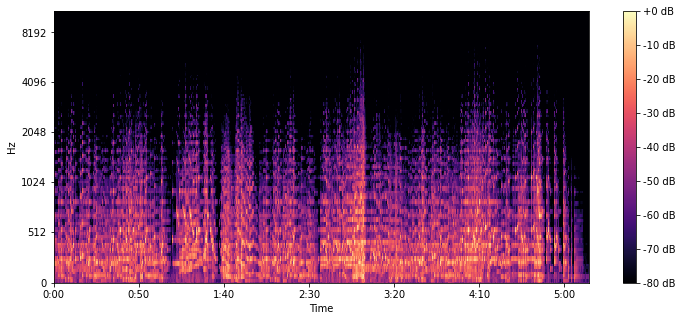

In [155]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(melspec_classical), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

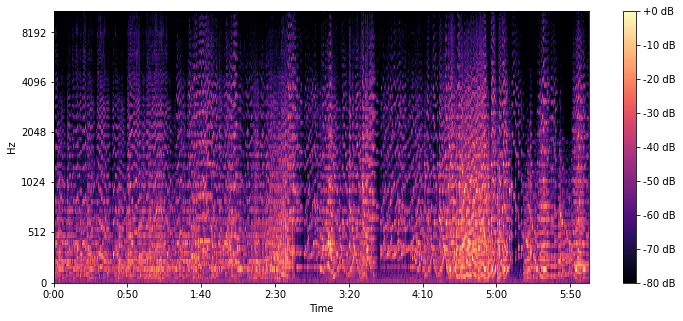

In [154]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_melspecs[0]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

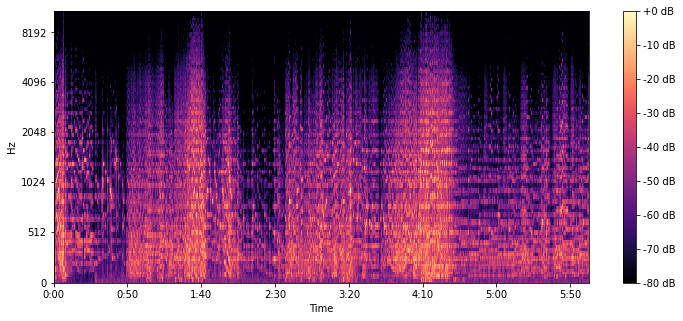

In [156]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_melspecs[1]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

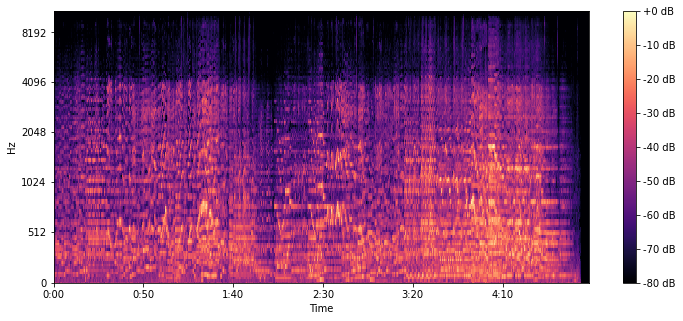

In [157]:
fig, ax = plt.subplots(figsize=(12,5))
melspec_db = librosa.power_to_db(np.abs(top_melspecs[2]), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")